## Laattoe Periodic Boundary Condition

Periodic boundary condition problem is based on Laattoe and others (2014).
A MODFLOW 6 GWF-GWF Exchange is used to connect the left column with the
right column.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-spbc"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 190  # Number of layers
ncol = 100  # Number of columns
nrow = 1  # Number of rows
delr = 0.06  # Column width ($m$)
delc = 1.0  # Row width ($m$)
delv = 0.03  # Layer thickness ($m$)
top = 0.0  # Top of the model ($m$)
strt = 0.0  # Starting head ($m$)
icelltype = 0  # Cell conversion type
hydraulic_conductivity = 1.0  # Horizontal hydraulic conductivity ($m/d$)

# Static temporal data used by TDIS file
# Simulation has 1 steady stress period (1 day)
# and 3 transient stress periods (10 days each).
# Each transient stress period has 120 2-hour time steps.
perlen = [1.0]
nstp = [1]
tsmult = [1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

# assign botm
botm = [top - k * delv for k in range(1, nlay + 1)]

# Solver parameters
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    ihc, cl1, cl2, hwva = 1, delr / 2.0, delr / 2.0, delc
    angldegx = 90.0
    cdist = delr
    exgdata = [
        [(k, 0, 0), (k, 0, ncol - 1), ihc, cl1, cl2, hwva, angldegx, cdist]
        for k in range(nlay)
    ]
    exg = flopy.mf6.ModflowGwfgwf(
        sim,
        exgtype="GWF6-GWF6",
        nexg=len(exgdata),
        auxiliary=["ANGLDEGX", "CDIST"],
        exgmnamea=sim_name,
        exgmnameb=sim_name,
        exchangedata=exgdata,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=hydraulic_conductivity,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    hm = 1.0
    lmbda = ncol * delr
    wv = 2 * np.pi / lmbda
    x = gwf.modelgrid.xcellcenters
    chd_head = hm * np.sin(wv * x)
    chd_spd = []
    for j in range(ncol):
        chd_spd.append([0, 0, j, chd_head[0, j]])
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_spd,
        pname="CHD",
    )
    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=False):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 4)


def plot_grid(sim):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        # create MODFLOW 6 head object
        head = gwf.output.head().get_data()

        # create MODFLOW 6 cell-by-cell budget object
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            gwf.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0], gwf
        )

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
        # pxs.plot_grid()
        pxs.plot_bc(name="CHD")
        pxs.plot_array(head, cmap="jet")
        levels = np.arange(-1, 1, 0.1)
        cs = pxs.contour_array(
            head, levels=levels, colors="k", linewidths=1.0, linestyles="-"
        )
        pxs.plot_vector(qx, qy, qz, normalize=False, kstep=5, hstep=5)
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("z position (m)")
        ax.set_ylim(-3, 0)
        styles.remove_edge_ticks(ax)
        plt.clabel(cs, fmt="%3.1f", fontsize=5)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_results(sim, silent=True):
    plot_grid(sim)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 138.47 ms


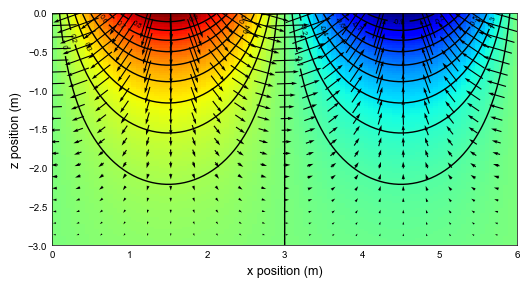

In [5]:
def scenario(silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)


scenario()